In [56]:
#import nessesary packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, f1_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc
import pandas as pd
import numpy as np
import json

In [57]:
#load data
data = pd.read_json('clothingreviewdata_cleaned.json')
data.head()

,star,review,unsatisfied
0,1 star: Bad,my partner buy 4 shirt for me believe it be a ...,1
1,1 star: Bad,i order a skirt in april this year and return ...,1
10,1 star: Bad,clothe be cheap look and smell look nothing li...,1
100,5 stars: Excellent,the fit be right the material be excellent and...,0
1000,5 stars: Excellent,i thoroughly enjoy this item i buy the fluffy ...,0


In [94]:
#create train-test split in data set
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['unsatisfied'], test_size=0.25, random_state=0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5061,) (5061,)
Test set: (1688,) (1688,)


In [72]:
#create pipeline with Count Vectorization and SVM model fit
objects = [("cv", CountVectorizer(stop_words='english', min_df=10)), 
           ("svm", SVC(probability=True))]
pipe = Pipeline(objects)

In [73]:
#define parameters (takes an ungodly amount of time to run through all of these parameters)
params = {'cv__ngram_range': ((1, 1), (1, 2), (1,3)), 
          'cv__max_df': (500, 1000, 2000, 5000),
          'svm__kernel': ('linear', 'sigmoid', 'poly', 'rbf'),
          'svm__C': (0.25, 0.75, 1, 1.5, 2),
          'svm__gamma': ('scale', 'auto')}

#create model with set pipeline and parameters; cross-validates in 4 folds 
grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=4, refit=True)

In [74]:
#fit model of train data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(min_df=10,
                                                        stop_words='english')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'cv__max_df': (500, 1000, 2000, 5000),
                         'cv__ngram_range': ((1, 1), (1, 2), (1, 3)),
                         'svm__C': (0.25, 0.75, 1, 1.5, 2),
                         'svm__gamma': ('scale', 'auto'),
                         'svm__kernel': ('linear', 'sigmoid', 'poly', 'rbf')})

In [88]:
#print out best parameters 
for param in grid_search.best_params_.items():
    print(param)
    
for step in grid_search.best_estimator_.steps:
    print(step)

('cv__max_df', 1000)
('cv__ngram_range', (1, 3))
('svm__C', 0.25)
('svm__gamma', 'scale')
('svm__kernel', 'linear')
('cv', CountVectorizer(max_df=1000, min_df=10, ngram_range=(1, 3),
                stop_words='english'))
('svm', SVC(C=0.25, kernel='linear', probability=True))


In [89]:
#get best estimator score
print('Best Estimator Score:', grid_search.best_score_)

Best Estimator Score: 0.9723374794722415


In [95]:
#get predictions and estimated probabilities for SVM model 
gridbest_predictions = grid_search.predict(X_test)
gridbest_prob = grid_search.predict_proba(X_test)

                 precision    recall  f1-score   support

  Satisfied (0)     0.9780    0.9735    0.9757      1095
Unsatisfied (1)     0.9515    0.9595    0.9555       593

       accuracy                         0.9686      1688
      macro avg     0.9647    0.9665    0.9656      1688
   weighted avg     0.9687    0.9686    0.9686      1688

Best Estimator Score: 0.9723374794722415


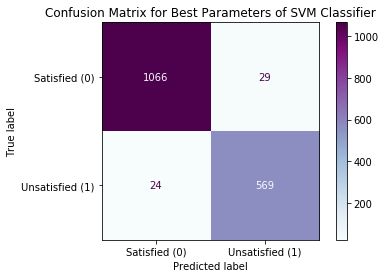

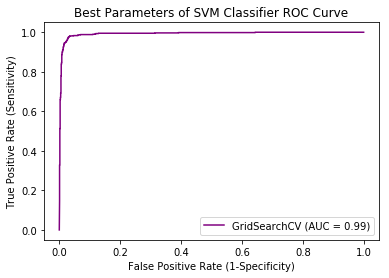

In [98]:
#create classification report
print (classification_report(y_test, gridbest_predictions, labels=[0, 1], target_names=['Satisfied (0)', "Unsatisfied (1)"], digits=4))
#create confusion matrix
display = pcm(grid_search, X_test, y_test, display_labels=['Satisfied (0)', "Unsatisfied (1)"], cmap='BuPu')
display.ax_.set_title('Confusion Matrix for Best Parameters of SVM Classifier')

#create ROC plot
plt = plot_roc_curve(grid_search, X_test, y_test, color="purple")  
plt.ax_.set_title('Best Parameters of SVM Classifier ROC Curve')
plt.ax_.set_xlabel('False Positive Rate (1-Specificity)')
plt.ax_.set_ylabel('True Positive Rate (Sensitivity)')

#print out other best classifier evaluation scores 
print('Best Estimator Score:', grid_search.best_score_)

In [79]:
#classify additional created data
print('Classification:', grid_search.predict(['i cannot believe how affordable and gorgeous these clothes are i would highly recommend zaful to anyone looking to update their wardrobe on a budget']))
print('Certainty: ', grid_search.predict_proba(['i cannot believe how affordable and gorgeous these clothes are i would highly recommend zaful to anyone looking to update their wardrobe on a budget']))

Classification: [0]
Certainty:  [[0.98993668 0.01006332]]


In [80]:
print('Classification: ', grid_search.predict(['never buy from zaful the clothing is very affordable but the quality is also trash i ordered 3 items from zaful and they all have some kind of fit issue or damage when i asked customer service about getting a refund for the items that were damaged upon arrival they were very rude and unhelpful i am still fighing them for the refund awful company']))
print('Certainty: ', grid_search.predict_proba(['never buy from zaful the clothing is very affordable but the quality is also trash i ordered 3 items from zaful and they all have some kind of fit issue or damage when i asked customer service about getting a refund for the items that were damaged upon arrival they were very rude and unhelpful i am still fighing them for the refund awful company']))

Classification:  [1]
Certainty:  [[0.19293785 0.80706215]]


In [81]:
print('Classification: ', grid_search.predict(['zaful has a great selection of clothes for people of all tastes and styles my sister and i can both shop here even though we have completely different senese of fashion we both get super excited every time we recieve their clothes because it has almost always exceeded our expectations delivery can be a little slow and unreliable, but their affordable clothes are definitely worth the wait'])) 
print('Certainty: ', grid_search.predict_proba(['zaful has a great selection of clothes for people of all tastes and styles my sister and i can both shop here even though we have completely different senese of fashion we both get super excited every time we recieve their clothes because it has almost always exceeded our expectations delivery can be a little slow and unreliable, but their affordable clothes are definitely worth the wait'])) 

Classification:  [0]
Certainty:  [[9.99688352e-01 3.11648155e-04]]
